In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Loading functions
import os
from monai.networks.nets import SwinUNETR
from functools import partial

import torch
import torch.nn.parallel
import logging
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)
import torch
import wandb



# Funciones de carga y preprocesameinto

In [3]:
 #Transformaciones
val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys="image"), #Leer imagenes    
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True), #Normalizar intensidades
    ]
)

# Dado un arreglo de paths de imagenes devuelve un tensor torch.Size([canales, x, y, z])
def get_image_data(image, transform):
    data = transforms.apply_transform(
                transform,
                data= {"image":image},
            )
    return data["image"]   
    


/home/minigo/anaconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


# Crear el modelo y asignarle los pesos

In [4]:
######################
# Crear el modelo
######################

### Hyperparameter
roi = (128, 128, 64)  # (128, 128, 128)

# Create Swin transformer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=11,
    out_channels=2,  # mdificar con edema
    feature_size=96,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
)#.to(device)



In [ ]:
run = wandb.init()
# artifact = run.use_artifact('mlops-team89/Swin_UPENN_106cases/mjkearkn_best_model:v0', type='model')
artifact = run.use_artifact('mlops-team89/Swin_UPENN_10cases/002u8pap_best_model:v0', type='model')
artifact_dir = artifact.download()
print(artifact_dir)

# model.to(device)
# model.load_state_dict(torch.load(os.path.join("./trained", "best_metric_model.pth"), map_location=torch.device('cpu')))
# model.eval()

In [5]:
#model.load_state_dict(torch.load(os.path.join(artifact_dir, "model.pt"), map_location=torch.device('cpu')))

# model_path = os.path.join(artifact_dir, "model.pt")
model_path = 'Dataset/model_dataset_330_30_64x64x64_v01.pt' # 5mm - mjkearkn_best_model-v0 / 10mm - ip0bojmx_best_model-v0

# Load the model on CPU
loaded_model = torch.load(model_path, map_location=torch.device(device))["state_dict"]
# model.load_state_dict(torch.load(model_path)["state_dict"])

# Load the state dictionary into the model
#model.load_state_dict(loaded_model)

# Move the model to the desired device (e.g., GPU) if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(11, 96, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=96, out_features=384, bias=True)
              (linear2): Linear(in_featur

# Cargar las imágenes

In [28]:
import glob
# Path de las imágenes para hacer la inferencia
# T1_path="./Dataset/UPENN-GBM-00002_11/UPENN-GBM-00002_11_T1.nii.gz"
# T2_path="./Dataset/UPENN-GBM-00002_11/UPENN-GBM-00002_11_T2.nii.gz"
# Flair_path="./Dataset/UPENN-GBM-00002_11/UPENN-GBM-00002_11_FLAIR.nii.gz"
# T1GDT_path="./Dataset/UPENN-GBM-00002_11/UPENN-GBM-00002_11_T1GD.nii.gz"

# Formar el vector de imágenes y realizar la transformación
def obtener_imagen(dataset, img_n):
    
    # DSC images
    DSC_ap_rCBV_list = sorted(glob.glob(f"{dataset}/images_DSC/UPENN-GBM-*/*_11_DSC_ap-rCBV.nii.gz"))
    DSC_PH_list = sorted(glob.glob(f"{dataset}/images_DSC/UPENN-GBM-*/*_11_DSC_PH.nii.gz"))
    DSC_PSR_list = sorted(glob.glob(f"{dataset}/images_DSC/UPENN-GBM-*/*_11_DSC_PSR.nii.gz"))
    # DTI images
    DTI_AD_list = sorted(glob.glob(f"{dataset}/images_DTI/UPENN-GBM-*/*_11_DTI_AD.nii.gz"))
    DTI_FA_list = sorted(glob.glob(f"{dataset}/images_DTI/UPENN-GBM-*/*_11_DTI_FA.nii.gz"))
    DTI_RD_list = sorted(glob.glob(f"{dataset}/images_DTI/UPENN-GBM-*/*_11_DTI_RD.nii.gz"))
    DTI_TR_list = sorted(glob.glob(f"{dataset}/images_DTI/UPENN-GBM-*/*_11_DTI_TR.nii.gz"))
    # Structural images
    FLAIR_list = sorted(glob.glob(f"{dataset}/images_structural/UPENN-GBM-*/*_11_FLAIR.nii.gz"))
    T1_list = sorted(glob.glob(f"{dataset}/images_structural/UPENN-GBM-*/*_11_T1.nii.gz"))
    T1GD_list = sorted(glob.glob(f"{dataset}/images_structural/UPENN-GBM-*/*_11_T1GD.nii.gz"))
    T2_list = sorted(glob.glob(f"{dataset}/images_structural/UPENN-GBM-*/*_11_T2.nii.gz"))

    images=[DSC_ap_rCBV_list[img_n], DSC_PH_list[img_n], DSC_PSR_list[img_n], 
            DTI_AD_list[img_n], DTI_FA_list[img_n], DTI_RD_list[img_n], DTI_TR_list[img_n], 
            FLAIR_list[img_n], T1_list[img_n], T1GD_list[img_n], T2_list[img_n]] # Deben respetar este orden - T1GD_list[img_n]
    
    directory = os.path.dirname(FLAIR_list[img_n])
    print(images[8])

    template = nib.load(images[0])
    header, affine = template.header, template.affine

    image_data=get_image_data(images, val_transform)
    #print(image_data.shape)
    return image_data, header, affine, directory


#image_data, header, affine, directory = obtener_imagen(dataset, img_n)

In [31]:
img_n=0
dataset="./Dataset/Dataset_106_30_casos/test/images"
image_data, header, affine, directory = obtener_imagen(dataset, img_n)
print(f"Image shape: {image_data.shape}")

./Dataset/Dataset_106_30_casos/test/images/images_structural/UPENN-GBM-00036_11/UPENN-GBM-00036_11_T1.nii.gz
Image shape: torch.Size([11, 240, 240, 155])


# Correr inferencia y visualizar salidas

In [9]:
post_trans = transforms.Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)] # argmax=True / threshold=0.5
)

roi_t= (128, 128, 64)

def inference(input, model):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(roi_t[0], roi_t[1], roi_t[2]), #roi_t[0], roi_t[1], roi_t[2] #(240, 240, 160)
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )
    return _compute(input)
    

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi_t[0], roi_t[1], roi_t[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
) 

# hacer inferencia
def inferir(image_data, model):
        
    with torch.no_grad():
        val_input = image_data.unsqueeze(0).to(device)
        #print(val_input.shape)
        val_output = model_inferer_test(val_input) # inference(val_input, model) - model_inferer_test(val_input)
        # val_output = post_trans(val_output[0])
        # print("Inferencia realizada")
    return val_output

In [14]:
# Salvar imagenes .nii.gz
def save_img(I_img,savename,header=None,affine=None):
    if header is None or affine is None:
        affine = np.diag([1, 1, 1, 1])
        new_img = nib.nifti1.Nifti1Image(I_img, affine, header=None)
    else:
        new_img = nib.nifti1.Nifti1Image(I_img, affine, header=header)

    nib.save(new_img, savename)

In [32]:
output = inferir(image_data, model)
print("Output: ",output.shape)


Output:  torch.Size([1, 2, 240, 240, 155])


In [36]:
original= output[0].detach().cpu().numpy()

prob = torch.sigmoid(output)
print("Prob: ",prob[0].shape)

seg = prob[0].detach().cpu().numpy()
seg = (seg > 0.5).astype(np.int8)
print(seg.shape)

seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
print(seg_out.shape)
seg_out[seg[1] == 1] = 1
seg_out[seg[0] == 1] = 4
# Nueva línea para la intersección utilizando 'and'
seg_out[(seg[0] == 1) & (seg[1] == 1)] = 2

Prob:  torch.Size([2, 240, 240, 155])
(2, 240, 240, 155)
(240, 240, 155)


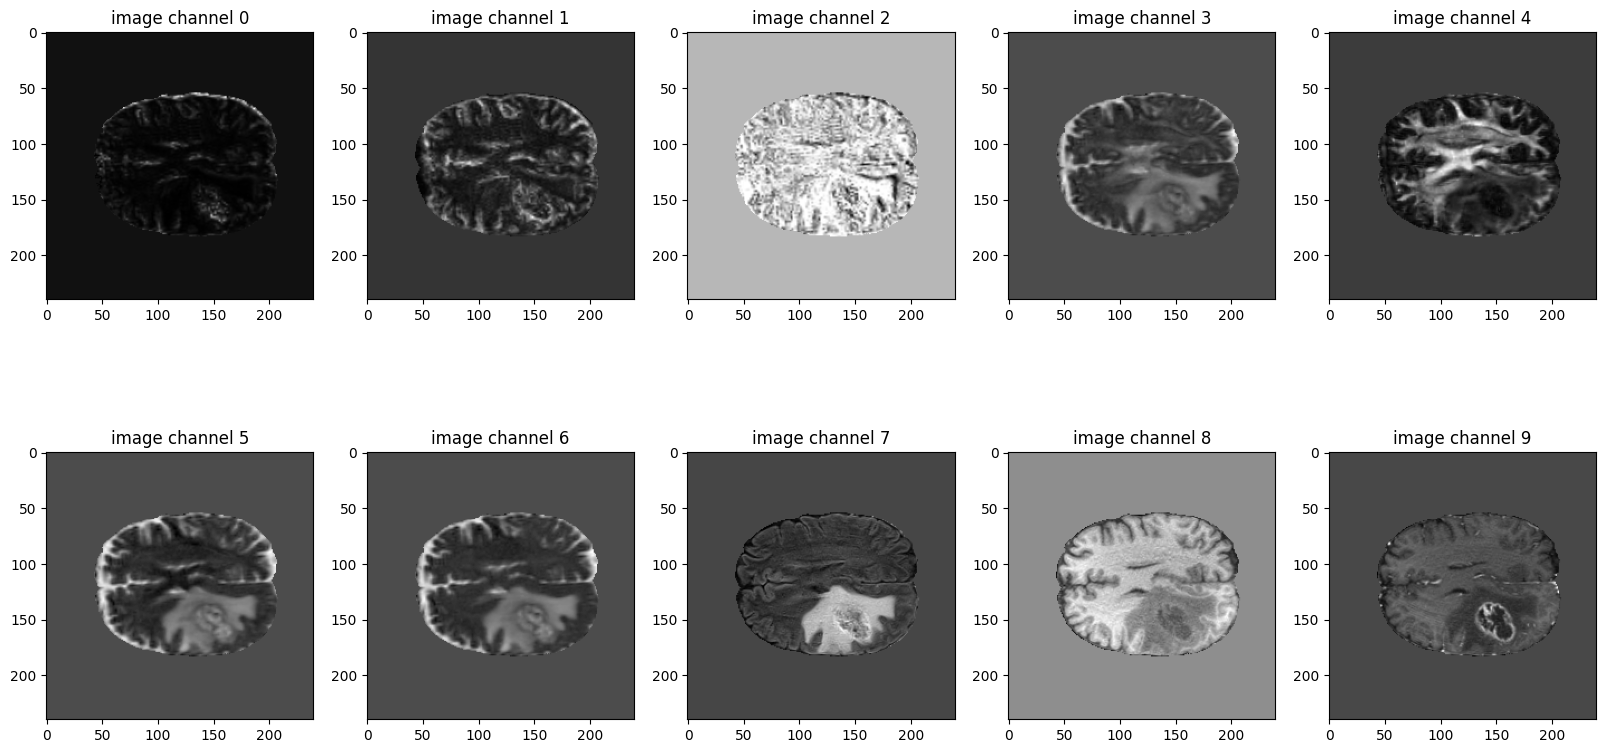

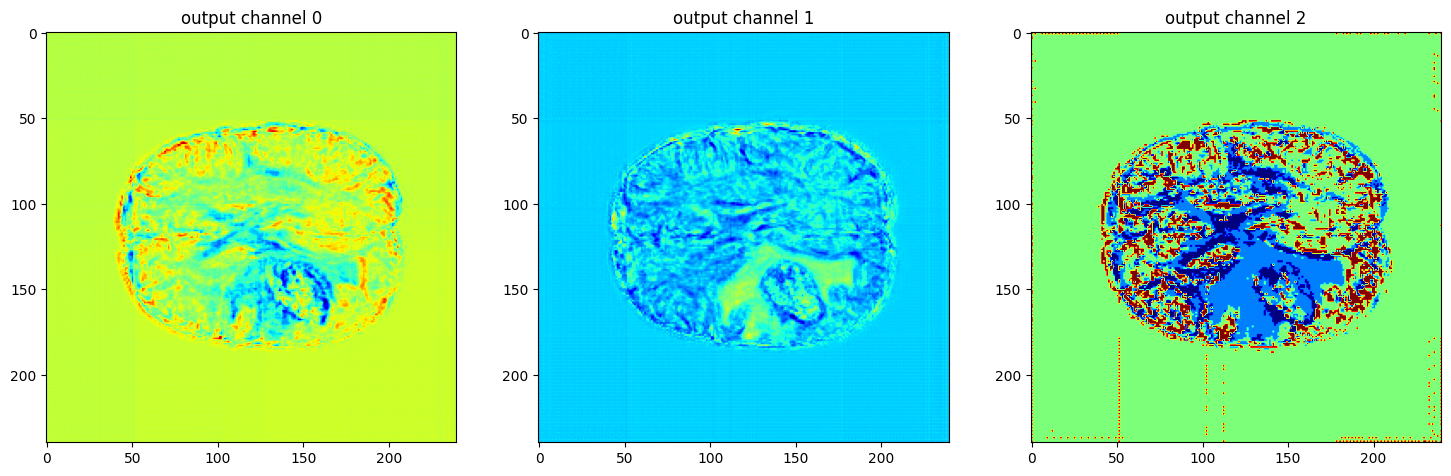

In [37]:
sl=90

plt.figure("image", (20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(image_data[i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()
# visualize the 3 channels model output corresponding to this image
plt.figure("output", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"output channel {i}")
    if i==2:
        plt.imshow(seg_out[:,:,sl], cmap="jet")
    else:
        plt.imshow(original[i,:,:,sl], cmap="jet") #.detach().cpu()
plt.show()

In [16]:
# Crear un nuevo tensor de ceros con el tamaño deseado
output_tensor = torch.zeros(240, 240, 155, dtype=torch.float32)

# output_tensor += val_output[1] * 2  # necrosis
# output_tensor += val_output[0] * 3 # edema
# output_tensor += val_output[2] * 4  # activo
directory="trained_models/segmentations_pruebas"

save_img(
            seg_out, #output_tensor.numpy(),
            f"{directory}/{img_n}segmentation.nii.gz",
            header,
            affine,
        )
save_img(
            original[0], #output_tensor.numpy(),
            f"{directory}/{img_n}Nroi.nii.gz",
            header,
            affine,
        )
save_img(
            original[1], #output_tensor.numpy(),
            f"{directory}/{img_n}Froi.nii.gz",
            header,
            affine,
        )
output_tensor.shape

torch.Size([240, 240, 155])

## Hacer inferencia sobre todos los casos

In [ ]:
dataset="./Dataset/Dataset_106_30_casos/test/images"
directory="./trained_models/segmentations"
for img_n in range(36):
    image_data, header, affine, directory = obtener_imagen(dataset, img_n)
    
    # val_output = inferir(image_data, model)
    # output_tensor = torch.zeros(240, 240, 155, dtype=torch.float32)
    # output_tensor += val_output[1] * 2  # necrosis
    # output_tensor += val_output[0] * 3 # edema
    # output_tensor += val_output[2] * 4  # activo
    output = inferir(image_data, model)
    original= output[0].detach().cpu().numpy()

    prob = torch.sigmoid(output)
    seg = prob[0].detach().cpu().numpy()
    seg = (seg > 0.9).astype(np.int8)

    seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
    seg_out[seg[1] == 1] = 4
    seg_out[seg[0] == 1] = 1
    # Nueva línea para la intersección utilizando 'and'
    seg_out[(seg[0] == 1) & (seg[1] == 1)] = 2

    
    save_img(
            seg_out, #output_tensor.numpy(),
            f"./trained_models/segmentations/{img_n}segmentation.nii.gz",
            header,
            affine,
        )
    save_img(
            original[0], #output_tensor.numpy(),
            f"./trained_models/segmentations/{img_n}Nroi.nii.gz",
            header,
            affine,
        )
    save_img(
            original[1], #output_tensor.numpy(),
            f"./trained_models/segmentations/{img_n}Froi.nii.gz",
            header,
            affine,
        )
    print(f"Image {img_n} saved at {directory}")

# cargar segmentaciones

In [4]:
import os
img_n=0
path_to_img=f"./trained_models/segmentations_pruebas"
path_to_img_nroi=os.path.join(path_to_img, f"{img_n}Nroi.nii.gz")
img_nroi = nib.load(path_to_img_nroi).get_fdata()
path_to_img_froi=os.path.join(path_to_img, f"{img_n}Froi.nii.gz")
img_froi = nib.load(path_to_img_froi).get_fdata()

# Convertir las matrices NumPy en tensores de PyTorch
tensor1 = torch.from_numpy(img_nroi)
tensor2 = torch.from_numpy(img_froi)

# Combinar los tensores en un tensor de forma (2, 240, 240, 155)
output= torch.stack((tensor1, tensor2))
# Probabilidades
prob=torch.sigmoid(output) #softmax(output, dim=0)
# Seg
seg = prob.detach().cpu().numpy()

# Verificar la forma del tensor combinado
print(output.shape)
print(prob.shape)
print(seg.shape)

torch.Size([2, 240, 240, 155])
torch.Size([2, 240, 240, 155])
(2, 240, 240, 155)


In [42]:
# seg = (seg > 0.5).astype(np.int8)
# print(seg.shape)

# seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
# print(seg_out.shape)
# seg_out[seg[1] == 1] = 1
# seg_out[seg[0] == 1] = 4
# # Nueva línea para la intersección utilizando 'and'
# seg_out[(seg[0] == 1) & (seg[1] == 1)] = 2

(2, 240, 240, 155)
(240, 240, 155)


In [5]:
# Crear el volumen cuantizado con el mismo tamaño que una de las capas
seg_out = np.zeros((240, 240, 155), dtype=int)
seg_c = (seg > 0.9)
# Asignar valores al volumen cuantizado
seg_out[seg_c[0] > seg_c[1]] = 4
seg_out[seg_c[0] < seg_c[1]] = 1
seg_out[(seg_c[0] == seg_c[1]) & (seg_c[0]!=0) & (seg_c[1]!=0) ] = 2

# Verificar los resultados
print(seg_out.shape)


(240, 240, 155)


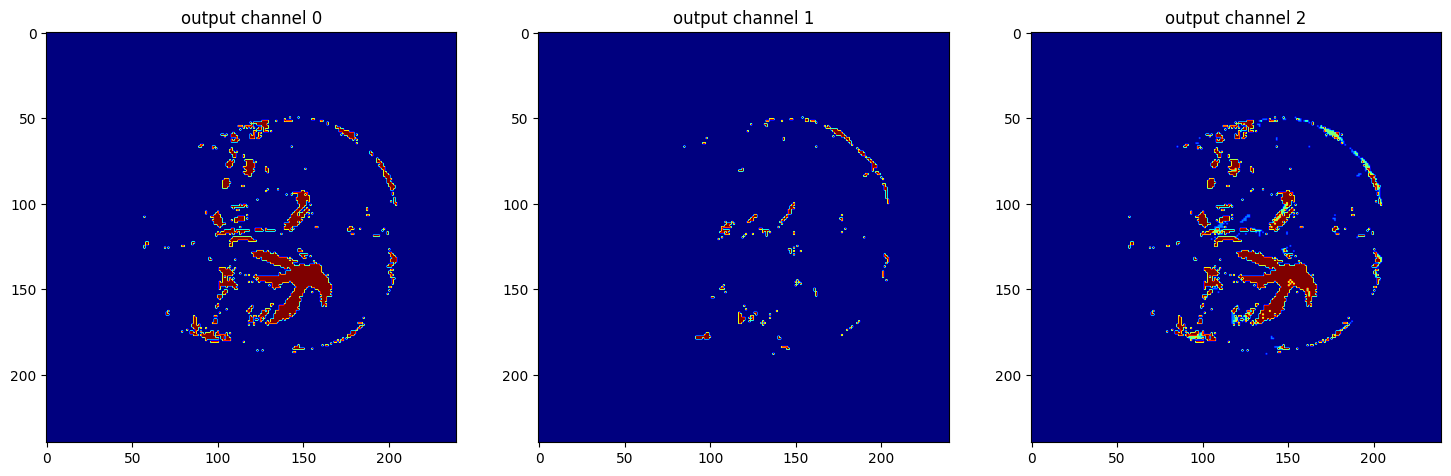

In [8]:
sl=84

plt.figure("output", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"output channel {i}")
    if i==2:
        #pass
        plt.imshow(seg_out[:,:,sl], cmap="jet") #seg_out
    else:
        plt.imshow(seg_c[i,:,:,sl], cmap="jet") #.detach().cpu()
plt.show()

In [69]:
dataset="./Dataset/Dataset_106_30_casos/test/images"
_, header, affine, _ = obtener_imagen(dataset, img_n)

directory="trained_models/segmentations"
save_img(
            seg_out, #output_tensor.numpy(),
            f"{directory}/{img_n}segmentation_nroi.nii.gz",
            header,
            affine,
        )

./Dataset/Dataset_106_30_casos/test/images/images_structural\UPENN-GBM-00036_11\UPENN-GBM-00036_11_T1.nii.gz


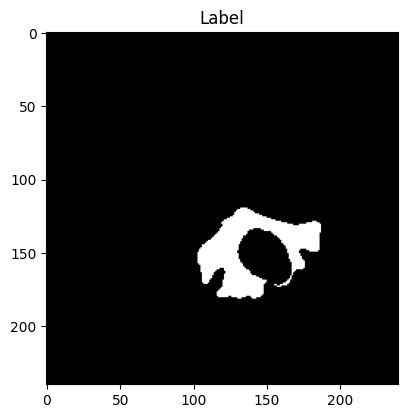

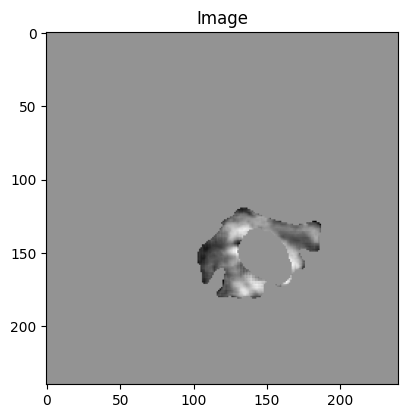

In [9]:
import matplotlib.pyplot as plt
img_n=0
slice_n=90
dataset_labels = "./Dataset/Dataset_106_30_casos/test/labels"
label_list = sorted(glob.glob(f"{dataset_labels}/UPENN-GBM-*_11_automated_approx_segm.nii.gz"))
img_label = nib.load(label_list[img_n]).get_fdata()
roi_mask = (img_label == 2)

# Visualizar un slice
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Label")
plt.imshow(roi_mask[:, :, slice_n], cmap="gray")

path_to_img=f"D:\\Alexander\\1_Doctorado\\Software\\DIRAC-main\\outputs"
path_to_img_nroi=os.path.join(path_to_img, f"{img_n}Nroi.nii.gz")
img_nroi = nib.load(path_to_img_nroi).get_fdata()
tensor_nroi=torch.from_numpy(img_nroi)

tensor_nroi[roi_mask==0]=0
# Visualizar un slice
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(tensor_nroi[:, :, slice_n], cmap="gray")



In [7]:
def mapminmax(tensor, min_val=-1, max_val=1):
    tensor_min = tensor.min()
    print('Min:',tensor_min)
    tensor_max = tensor.max()
    print('Max:',tensor_max)
    scaled_tensor = (tensor - tensor_min) / (tensor_max - tensor_min) * (max_val - min_val) + min_val
    return scaled_tensor

def get_min_value(tensor, label):
    # 1. Crear la máscara para la ROI (donde los valores en label son 2)
    roi_mask = (label == 2)

    #2. Aplicar la máscara al tensor de imagen
    roi_values = tensor[roi_mask]

    # 3. Identificar y eliminar solo outliers mínimos usando el método IQR
    q1 = torch.quantile(roi_values, 0.25)
    iqr = q1 - torch.quantile(roi_values, 0.10)  # Usar el IQR basado en Q1 y el percentil 10%
    lower_bound = q1 - 1.5 * iqr

    # Definir el límite inferior usando solo P10 para identificar outliers mínimos
    # lower_bound = torch.quantile(roi_values, 0.1) 

    # Filtrar valores que están por encima del límite inferior
    filtered_values = roi_values[roi_values >= lower_bound]

    # 4. Obtener el valor mínimo dentro de los valores filtrados
    return filtered_values.min()

def apply_temperature_scaling(logits, temperature):
    # Escalar los logits con la temperatura óptima
    scaled_logits = logits / temperature
    # Convertir los logits escalados en probabilidades con la función sigmoide
    probabilities = torch.sigmoid(scaled_logits)
    return probabilities

In [10]:
dataset="./Dataset/Dataset_106_30_casos/test/images"
directory="./trained_models/segmentations_scale"
_, header, affine, _ = obtener_imagen(dataset, img_n)

for img_n in range(36): #36
    path_to_img=f"D:\\Alexander\\1_Doctorado\\Software\\DIRAC-main\\outputs"
    path_to_img_nroi=os.path.join(path_to_img, f"{img_n}Nroi.nii.gz")
    img_nroi = nib.load(path_to_img_nroi).get_fdata()
    path_to_img_froi=os.path.join(path_to_img, f"{img_n}Froi.nii.gz")
    img_froi = nib.load(path_to_img_froi).get_fdata()

    img_label = nib.load(label_list[img_n]).get_fdata()
    tensor_label = torch.from_numpy(img_label)

    # Convertir las matrices NumPy en tensores de PyTorch
    tensor_nroi = torch.from_numpy(img_nroi)
    # min_value = get_min_value(tensor_nroi, tensor_label) # Obtener el menor valor dentrodel edema
    # #print("min nroi", min_value)
    # tensor_nroi[tensor_nroi < min_value] = min_value 

    tensor_froi = torch.from_numpy(img_froi)
    # min_value = get_min_value(tensor_froi, tensor_label) # Obtener el menor valor dentro del edema
    # #print("min froi", min_value)
    # tensor_froi[tensor_froi < min_value] = min_value 

    # Escalar los tensores usando mapminmax
    # tensor_nroi = mapminmax(tensor_nroi)
    # tensor_froi = mapminmax(tensor_froi)

    # Combinar los tensores en un tensor de forma (2, 240, 240, 155)
    output= torch.stack((tensor_nroi, tensor_froi))
    # Probabilidades
    prob=apply_temperature_scaling(output, temperature=1.3460201025009155) #torch.sigmoid(output) #softmax(output, dim=0)
    # Seg
    seg = prob.detach().cpu().numpy()
    # Save probs
    save_img(
            seg[0], #output_tensor.numpy(), seg_out,
            f"{directory}/{img_n}nroi_prob.nii.gz",
            header,
            affine,
        )
    save_img(
            seg[1], #output_tensor.numpy(), seg_out,
            f"{directory}/{img_n}froi_prob.nii.gz",
            header,
            affine,
        )

    # Crear el volumen cuantizado con el mismo tamaño que una de las capas
    seg_out = np.zeros((240, 240, 155), dtype=int)
    seg_b = (seg > 0.5)
    seg[seg_b==0]=0
    #seg=(seg > 0.5)

    # Asignar valores al volumen cuantizado
    seg_out[seg[0] > seg[1]] = 4
    seg_out[seg[0] < seg[1]] = 1
    seg_out[(seg[0] == seg[1]) & (seg[0]!=0) & (seg[1]!=0) ] = 2

    # Salvar la imagen segmentada
    save_img(
            seg_out, #output_tensor.numpy(), seg_out,
            f"{directory}/{img_n}segmentation.nii.gz",
            header,
            affine,
        )
    
    print(f"Segmentation {img_n} saved successfully.")

./Dataset/Dataset_106_30_casos/test/images/images_structural\UPENN-GBM-00036_11\UPENN-GBM-00036_11_T1.nii.gz
Segmentation 0 saved successfully.
Segmentation 1 saved successfully.
Segmentation 2 saved successfully.
Segmentation 3 saved successfully.
Segmentation 4 saved successfully.
Segmentation 5 saved successfully.
Segmentation 6 saved successfully.
Segmentation 7 saved successfully.
Segmentation 8 saved successfully.
Segmentation 9 saved successfully.
Segmentation 10 saved successfully.
Segmentation 11 saved successfully.
Segmentation 12 saved successfully.
Segmentation 13 saved successfully.
Segmentation 14 saved successfully.
Segmentation 15 saved successfully.
Segmentation 16 saved successfully.
Segmentation 17 saved successfully.
Segmentation 18 saved successfully.
Segmentation 19 saved successfully.
Segmentation 20 saved successfully.
Segmentation 21 saved successfully.
Segmentation 22 saved successfully.
Segmentation 23 saved successfully.
Segmentation 24 saved successfully.
S